In [2]:
import numpy as np
import matplotlib.pyplot as plt
from simulation import inverse_kinematics_objective, draw_solutions
from idea import IDEA

In [17]:
rectangles = [((0.4, 2.), (5., 4.)), ((-5., 2.), (-0.8, 4.)), ((-0.5, 2.), (0.1, 4.)),
              ((-5., 5.), (-0.4, 6.)), ((-0.2, 5.), (5., 6.))]
target_x = 1.
target_y = 8.
S = [0.7] * 10 + [0.3] * 10
d = len(S)
x_min = -np.pi
x_max = np.pi

objective = inverse_kinematics_objective(S, (target_x, target_y), rectangles)
n_constraints = len(rectangles)

n = 600
n_inf = int(0.7*n)
eta_c = 3.
eta_m = 20.
p_c = 0.9
p_m = 0.05
num_iterations = 200

populations, scores = IDEA(objective, n_constraints, x_min, x_max, d, n, n_inf, eta_c, eta_m, p_c, p_m, num_iterations, log_interval=20)

Iteration 0, #feasible: 302, best: [37.89437072], #infeasible: 298, best: [11.41142714  1.        ]
Iteration 20, #feasible: 180, best: [28.62672349], #infeasible: 420, best: [0.16005958 1.        ]
Iteration 40, #feasible: 180, best: [11.15278275], #infeasible: 420, best: [0.00327447 1.        ]
Iteration 60, #feasible: 180, best: [9.53578859], #infeasible: 420, best: [2.59679697e-05 1.00000000e+00]
Iteration 80, #feasible: 180, best: [9.43667904], #infeasible: 420, best: [5.33643464e-07 1.00000000e+00]
Iteration 100, #feasible: 180, best: [9.36033565], #infeasible: 420, best: [2.65412508e-07 1.00000000e+00]
Iteration 120, #feasible: 180, best: [0.00446489], #infeasible: 420, best: [1.46194601e-08 1.00000000e+00]
Iteration 140, #feasible: 180, best: [3.05263039e-05], #infeasible: 420, best: [2.93266204e-10 1.00000000e+00]
Iteration 160, #feasible: 180, best: [2.78926433e-09], #infeasible: 420, best: [3.96376948e-12 1.00000000e+00]
Iteration 180, #feasible: 180, best: [7.7543959e-10], 

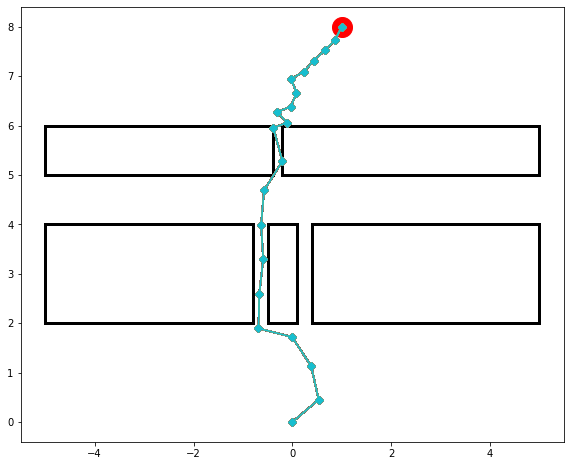

In [18]:
mask = scores[-1, :, 1] == 0.
feasible_population = populations[-1][mask, :]
draw_solutions(feasible_population, S, (target_x, target_y), rectangles, figsize=(10, 8))

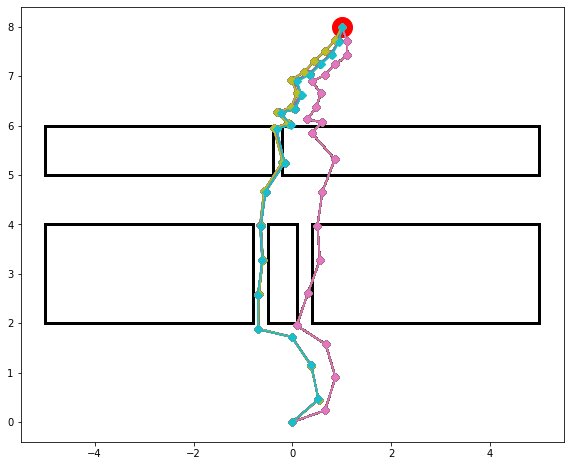

In [19]:
infeasible_population = populations[-1][~mask, :]
draw_solutions(infeasible_population, S, (target_x, target_y), rectangles, figsize=(10, 8))